In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import pandas as pd
import sys

# Define the base path to the input dataset and other paths
BASE_PATH = "/content/drive/MyDrive/Bangkit/Expiry Date.v5i.tensorflow/train"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "image"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "_annotations.csv"])
BASE_OUTPUT = "/content/drive/MyDrive/Bangkit/output"
MODEL_PATH = os.path.sep.join([ "detector.h5"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])
INIT_LR = 4e-4
NUM_EPOCHS = 30
BATCH_SIZE = 16

# Load the contents of the CSV annotations file
print("[INFO] Loading dataset...")
# Load the contents of the CSV annotations file using pandas
annotations = pd.read_csv(ANNOTS_PATH)

# Initialize data, targets, and filenames lists
data = []
targets = []
filenames = []

# Loop over the annotations
for index, row in annotations.iterrows():
    filename = row['filename']
    imagePath = os.path.sep.join([IMAGES_PATH, filename])

    if not os.path.exists(imagePath):
        continue

    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)

    # Ensure 'xmin', 'ymin', 'xmax', 'ymax' are available in the data
    if 'xmin' not in row or 'ymin' not in row or 'xmax' not in row or 'ymax' not in row:
        print(f"Bounding box coordinates not found in row: {row}")
        continue

    startX = float(row['xmin']) / w
    startY = float(row['ymin']) / h
    endX = float(row['xmax']) / w
    endY = float(row['ymax']) / h

    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

# Convert lists to NumPy arrays
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

testFilenames = []
if len(data) > 0:
    split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)
    (trainImages, testImages) = split[:2]
    (trainTargets, testTargets) = split[2:4]
    (trainFilenames, testFilenames) = split[4:6]
    print(f"Number of training samples: {len(trainImages)}")
    print(f"Number of testing samples: {len(testImages)}")
else:
    print("[ERROR] Insufficient data to split into training and testing sets.")
    print("Number of total samples:", len(data))
    sys.exit()

# Save testing filenames to a file
print("[INFO] Saving testing filenames...")
with open(TEST_FILENAMES, "w") as f:
    f.write("\n".join(testFilenames))

[INFO] Loading dataset...
Number of training samples: 954
Number of testing samples: 107
[INFO] Saving testing filenames...


In [ ]:
# Load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False

# Flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# Construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(256, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# Construct the model for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [ ]:
# Load the pre-trained weights into the model
model.load_weights(MODEL_PATH)

# Modify the output layer for fine-tuning
model.layers[-1] = Dense(4, activation="sigmoid")(model.layers[-2].output)

In [ ]:
print(f"Number of training samples: {len(trainImages)}")
print(f"Number of testing samples: {len(testImages)}")

Number of training samples: 954
Number of testing samples: 107


In [ ]:
# Compile the model for fine-tuning
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mse", optimizer=opt, metrics=['MeanSquaredError', 'accuracy'])

# Fine-tune the model
print("[INFO] Fine-tuning bounding box regressor...")
fine_tune_history = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1
)

[INFO] Fine-tuning bounding box regressor...
Epoch 1/30
60/60 [==============================] - 615s 10s/step - loss: 0.0162 - mean_squared_error: 0.0162 - accuracy: 0.7652 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_accuracy: 0.7850
Epoch 2/30
60/60 [==============================] - 613s 10s/step - loss: 0.0095 - mean_squared_error: 0.0095 - accuracy: 0.8491 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_accuracy: 0.8318
Epoch 3/30
60/60 [==============================] - 586s 10s/step - loss: 0.0053 - mean_squared_error: 0.0053 - accuracy: 0.9025 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_accuracy: 0.8598
Epoch 4/30
60/60 [==============================] - 607s 10s/step - loss: 0.0032 - mean_squared_error: 0.0032 - accuracy: 0.9151 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_accuracy: 0.8318
Epoch 5/30
60/60 [==============================] - 606s 10s/step - loss: 0.0025 - mean_squared_error: 0.0025 - accuracy: 0.9298 - val_loss

In [ ]:
# Save the fine-tuned model
fine_tuned_model_path = os.path.sep.join([BASE_OUTPUT, "fine_tuned_detector.h5"])
model.save(fine_tuned_model_path, save_format="h5")

# Plot the fine-tuning history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), fine_tune_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), fine_tune_history.history["val_loss"], label="val_loss")
plt.title("Fine-tuning Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(os.path.sep.join([BASE_OUTPUT, "fine_tune_plot.png"]))

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Bangkit/output/fine_tuned_detector.h5')

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from google.colab.patches import cv2_imshow

1/1 [==============================] - 0s 158ms/step


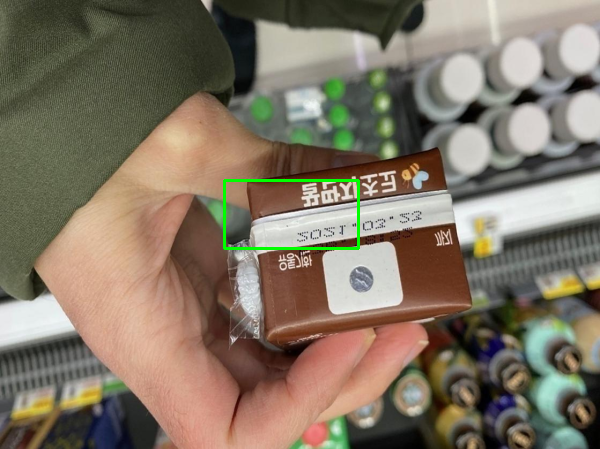

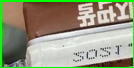

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import imutils
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Path to the saved object detection model
MODEL_PATH = "/content/drive/MyDrive/ColabNotebooks/BANGKIT/capstone/output/fine_tuned_detector.h5"

# Load the object detection model
model = load_model(MODEL_PATH)

# Path to the test image
test_image_path = "2.jpeg"

# Load the test image
image = cv2.imread(test_image_path)
image = imutils.resize(image, width=600)  # Resize for better visualization

# Preprocess the image for the object detection model
input_image = cv2.resize(image, (224, 224))
input_image = img_to_array(input_image) / 255.0
input_image = np.expand_dims(input_image, axis=0)

# Make bounding box predictions on the input image
preds = model.predict(input_image)[0]
(startX, startY, endX, endY) = preds

# # Scale the predicted bounding box coordinates based on the image dimensions
# (h, w) = image.shape[:2]
# startX = int(startX * w)
# startY = int(startY * h)
# endX = int(endX * w)
# endY = int(endY * h)

# Define scale factors (e.g., 1.5 for 1.5 times larger in width and 2.0 for 2 times larger in height)
scale_factor_width = 1.5
scale_factor_height = 4


# Scale the predicted bounding box coordinates based on the image dimensions and scale factor
(h, w) = image.shape[:2]
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

# Calculate the center of the bounding box
centerX, centerY = (startX + endX) // 2, (startY + endY) // 2

# # Calculate the new dimensions of the bounding box
# width = int((endX - startX) * scale_factor)
# height = int((endY - startY) * scale_factor)

# Calculate the new dimensions of the bounding box
width = int((endX - startX) * scale_factor_width)
height = int((endY - startY) * scale_factor_height)


# Recalculate the new starting and ending coordinates
startX = max(0, centerX - width // 2)
startY = max(0, centerY - height // 2)
endX = min(w, centerX + width // 2)
endY = min(h, centerY + height // 2)


# Draw the bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Display the output image with the bounding box
cv2_imshow(image)  # Mengganti cv2.imshow menjadi cv2_imshow

# Crop the image based on the adjusted bounding box coordinates
cropped_image = image[startY:endY, startX:endX]

# Display the cropped image
cv2_imshow(cropped_image)